In [1]:
import numpy as np
import pandas as pd
import scipy.io
from scipy import special
from scipy import optimize
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
import plotly.express as px
from datetime import date
from glob import glob
from os.path import join, exists
import random
from random import random as rand

from datetime import date

from tqdm import tqdm

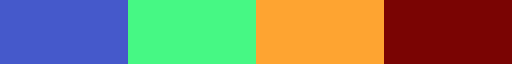

In [2]:
from matplotlib import cm, colors

tmp = cm.turbo(np.linspace(0.1,1.0,4))
palette = [colors.rgb2hex(rgb, keep_alpha=False) for rgb in tmp]

colors.ListedColormap(palette)

In [3]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

In [4]:
%config InlineBackend.figure_format = 'retina'
py.offline.init_notebook_mode(connected = True)

In [5]:
np.set_printoptions(precision=5, suppress=True)

In [6]:
dir_root = '/mnt/ext5/GP'

In [7]:
def convert_ID(ID):
    ##################   ##################
    #  1  2  3  4  5 #   #        2       #
    #  6  7  8  9 10 #   #        1       #
    # 11 12 13 14 15 # = # -2 -1  0  1  2 #
    # 16 17 18 19 20 #   #       -1       #
    # 21 22 23 24 25 #   #       -2       #
    ##################   ##################
    x = np.kron(np.ones(5),np.arange(-2,3)).astype(int)
    y = np.kron(np.arange(2,-3,-1),np.ones(5)).astype(int)
    pos = np.array((x[ID-1],y[ID-1]))
    return pos

In [8]:
def calc_hit(file_behav, tpr=97, nrun=6):
    ##### parameters #####
    ## file_behav: 불러올 .mat 파일 경로
    ## tpr: trial per run, default=97 (GA project)
    ## nrun: 불러올 run 수, 예) nrun=4 일 경우, r01~r04 까지 데이터를 불러옴
    
    datum = scipy.io.loadmat(file_behav)
    
    ## frame per trial
    fpt = int(datum['nSampleTrial'][0][0])
    ## second per trial
    spt = int(fpt/60.)
    ## a number of trials per run
    # tpr = datum['nTrialperRun'][0][0]
#     tpr = 97  # 12 trial/block * 8 block/run + 1 = 97 trial/run

    ## target ID
    tmp = datum['targetID'][0]
    targetID = tmp[tmp!=0][:tpr*nrun]

    bx = datum['boxSize'][0][0]
    pos = bx*convert_ID(targetID)
    
    ## 60 Hz * {5 s/trial * (1 trial + 12 trial/block * 8 block)}/Run * 3 Run = 87300
    allXY = datum['allXY']
    
    xFrame, yFrame = np.array([datum['xFrame'].squeeze(), datum['yFrame'].squeeze()]).astype(int)
    
    ## target position
    tmp = np.zeros(allXY.shape)
    for i in range(fpt*tpr*nrun):
        t = np.floor(i/fpt).astype(int)
        tmp[0][i], tmp[1][i] = pos[0][t], pos[1][t]

    ## Is it hit?
    err = allXY - tmp
    hit = np.zeros(fpt*tpr*nrun)
    for i in range(fpt*tpr*nrun):
        hit[i] = abs(err[0][i]) <= bx*.5 and abs(err[1][i]) <= bx*.5
        
    return hit

## GA

In [9]:
dir_work = '/home/sungbeenpark/Github/labs/GA'
dir_data = join(dir_work, 'behav_data')
list_behav = sorted(glob(join(dir_data, '*-fmri.mat')))

df_GA = pd.DataFrame(columns=['subj', 'group']+[block for block in range(8*6)], index=range(len(list_behav)))
for i, fname in enumerate(tqdm(list_behav)):
    subj = fname.split('/')[-1].split('-')[-2]
    df_GA.loc[i]['subj'] = subj
    df_GA.loc[i]['group'] = 'GA'
    hit = calc_hit(fname, tpr=97)
    for block in range(8*6):
        run = block // 8 + 1
        df_GA.loc[i][block] = hit[ 300*(12*block + run) : 300*(12*(block+1) + run) ].mean()

df_GA

100%|██████████| 30/30 [00:34<00:00,  1.16s/it]


,subj,group,0,1,2,3,4,5,6,7,...,38,39,40,41,42,43,44,45,46,47
0,GA01,GA,0.225833,0.221389,0.370833,0.316389,0.341389,0.389444,0.266667,0.379444,...,0.429167,0.43,0.3975,0.405,0.263889,0.265833,0.33,0.223333,0.338611,0.304722
1,GA02,GA,0.382778,0.487222,0.434722,0.219167,0.381111,0.498611,0.438333,0.391944,...,0.43,0.453611,0.36,0.458611,0.542222,0.489167,0.498611,0.498056,0.573889,0.533611
2,GA05,GA,0.040556,0.402222,0.246389,0.094167,0.221667,0.204167,0.045,0.206944,...,0.216111,0.394722,0.395556,0.446389,0.453333,0.299167,0.435556,0.452778,0.375833,0.531389
3,GA07,GA,0.146389,0.240833,0.07,0.1925,0.293056,0.286111,0.257222,0.196944,...,0.617778,0.565833,0.543333,0.374167,0.544167,0.540278,0.556667,0.598333,0.480278,0.5275
4,GA08,GA,0.263889,0.233056,0.411667,0.432222,0.258056,0.673889,0.530833,0.488611,...,0.348056,0.330556,0.437778,0.4675,0.421111,0.240556,0.444167,0.460556,0.348889,0.489722
5,GA11,GA,0.043611,0.206389,0.144722,0.168611,0.27,0.231111,0.255,0.241111,...,0.341389,0.4,0.335833,0.410278,0.235278,0.244444,0.264722,0.343056,0.343889,0.290556
6,GA12,GA,0.132222,0.1525,0.167222,0.368333,0.107778,0.115,0.289167,0.252778,...,0.439167,0.394167,0.365278,0.260556,0.492222,0.393889,0.335,0.450278,0.342222,0.440556
7,GA13,GA,0.135833,0.254444,0.338333,0.197778,0.2525,0.346389,0.458056,0.305,...,0.441111,0.640278,0.479722,0.466667,0.494444,0.605,0.432222,0.582222,0.532778,0.518333
8,GA14,GA,0.121944,0.128056,0.136944,0.138889,0.281667,0.16,0.0825,0.138056,...,0.186389,0.196389,0.076111,0.123611,0.2225,0.235833,0.236667,0.270833,0.311667,0.255
9,GA15,GA,0.108333,0.205278,0.293056,0.185556,0.237222,0.171389,0.233611,0.2225,...,0.648056,0.694167,0.556111,0.631389,0.660278,0.683333,0.665556,0.687778,0.682222,0.645


In [10]:
dir_work = '/home/sungbeenpark/Github/labs/GA'
dir_data = join(dir_work, 'behav_data')
list_behav = sorted(glob(join(dir_data, '*-refmri.mat')))

df_GB = pd.DataFrame(columns=['subj', 'group']+[block for block in range(8*6)], index=range(len(list_behav)))
for i, fname in enumerate(tqdm(list_behav)):
    subj = fname.split('/')[-1].split('-')[-2]
    df_GB.loc[i]['subj'] = subj.replace('GA','GB')
    df_GB.loc[i]['group'] = 'GB'
    hit = calc_hit(fname, tpr=97)
    for block in range(8*6):
        run = block // 8 + 1
        df_GB.loc[i][block] = hit[ 300*(12*block + run) : 300*(12*(block+1) + run) ].mean()

df_GB

100%|██████████| 30/30 [00:36<00:00,  1.23s/it]


,subj,group,0,1,2,3,4,5,6,7,...,38,39,40,41,42,43,44,45,46,47
0,GB01,GB,0.6625,0.800833,0.651667,0.809167,0.783333,0.798056,0.790556,0.819722,...,0.656944,0.726944,0.722222,0.710833,0.753611,0.740556,0.793056,0.739444,0.752778,0.798056
1,GB02,GB,0.731944,0.796389,0.824444,0.787778,0.803056,0.785556,0.823889,0.828333,...,0.650278,0.663611,0.644722,0.693611,0.695556,0.707778,0.639167,0.614167,0.600278,0.75
2,GB05,GB,0.508333,0.633611,0.722778,0.629722,0.694444,0.652778,0.591111,0.624167,...,0.604444,0.731667,0.437222,0.591944,0.596389,0.559444,0.537222,0.596944,0.666111,0.648889
3,GB07,GB,0.526944,0.752222,0.755,0.723611,0.709167,0.725278,0.703889,0.732222,...,0.5625,0.564722,0.622222,0.666944,0.660556,0.635556,0.700278,0.702222,0.538611,0.631111
4,GB08,GB,0.419444,0.646389,0.641389,0.565,0.718056,0.665556,0.731944,0.596667,...,0.396111,0.429444,0.428611,0.417222,0.431111,0.430278,0.483611,0.430556,0.624444,0.513056
5,GB11,GB,0.5975,0.6525,0.618889,0.605,0.555,0.576111,0.525278,0.679722,...,0.298611,0.322778,0.449444,0.390278,0.373889,0.210833,0.388889,0.412222,0.4175,0.296667
6,GB12,GB,0.562778,0.694722,0.5725,0.618056,0.6025,0.623333,0.606667,0.590833,...,0.286667,0.257222,0.319167,0.342778,0.215556,0.2025,0.354444,0.329444,0.333056,0.408333
7,GB13,GB,0.735833,0.726944,0.741111,0.696111,0.744722,0.774444,0.665278,0.6675,...,0.505278,0.383889,0.556111,0.612222,0.629722,0.5625,0.542778,0.597778,0.574167,0.526667
8,GB14,GB,0.471667,0.602778,0.605278,0.636111,0.694167,0.696389,0.639167,0.759722,...,0.42,0.542222,0.3975,0.468611,0.411111,0.520556,0.503056,0.519722,0.645556,0.61
9,GB15,GB,0.715,0.6825,0.771111,0.741667,0.731944,0.753889,0.751111,0.748056,...,0.436389,0.336667,0.431944,0.524444,0.51,0.598611,0.557778,0.593056,0.458333,0.569444


## GD

In [ ]:
dir_work = '/home/sungbeenpark/Github/labs/GD'
dir_data = join(dir_work, 'behav_data')
list_behav = sorted(glob(join(dir_data, '*-refmri.mat')))

df_GD = pd.DataFrame(columns=['subj', 'group']+[block for block in range(8*6)], index=range(len(list_behav)))
for i, fname in enumerate(tqdm(list_behav)):
    subj = fname.split('/')[-1].split('-')[-2]
    df_GD.loc[i]['subj'] = subj
    df_GD.loc[i]['group'] = 'GD'
    hit = calc_hit(fname, tpr=97)
    for block in range(8*6):
        run = block // 8 + 1
        df_GD.loc[i][block] = hit[ 300*(12*block + run) : 300*(12*(block+1) + run) ].mean()

df_GD

 20%|██        | 3/15 [00:03<00:14,  1.23s/it]

## GP

In [ ]:
list_dlPFC_cTBS = [
    '09', '10', '18', '21', '22'
    , '24', '27', '34', '35', '36'
    , '38', '42', '57', '59', '62'
    , '66', '67'
]
list_M1_cTBS = [
    '08', '11', '17', '19', '20'
    , '26', '32', '33', '37', '39'
    , '40', '41', '56', '58', '61'
    , '63', '65'
]
list_dlPFC_20Hz = [
    '43', '44', '45', '46', '47'
    , '48', '49', '50', '51', '53'
    , '54', '55'
]

- GP_DLPFC

In [ ]:
dir_data = join(dir_root, 'behav_data')

list_behav = []
for s in list_dlPFC_cTBS:
    list_behav.append(join(dir_data, 'GP%s-fmri.mat'%s))
    
df_GP_dlpfc = pd.DataFrame(columns=['subj', 'group']+[block for block in range(8*3)], index=range(len(list_behav)))
for i, fname in enumerate(tqdm(list_behav)):
    subj = fname.split('/')[-1].split('-')[-2]
    df_GP_dlpfc.loc[i]['subj'] = subj
    df_GP_dlpfc.loc[i]['group'] = 'GP_dlPFC_cTBS'
    hit = calc_hit(fname, tpr=97, nrun=3)
    for block in range(8*3):
        run = block // 8 + 1
        df_GP_dlpfc.loc[i][block] = hit[ 300*(12*block + run) : 300*(12*(block+1) + run) ].mean()

df_GP_dlpfc

- GP_M1

In [ ]:
dir_data = join(dir_root, 'behav_data')

list_behav = []
for s in list_M1_cTBS:
    list_behav.append(join(dir_data, 'GP%s-fmri.mat'%s))
    
df_GP_m1 = pd.DataFrame(columns=['subj', 'group']+[block for block in range(8*3)], index=range(len(list_behav)))
for i, fname in enumerate(tqdm(list_behav)):
    subj = fname.split('/')[-1].split('-')[-2]
    df_GP_m1.loc[i]['subj'] = subj
    df_GP_m1.loc[i]['group'] = 'GP_M1_cTBS'
    hit = calc_hit(fname, tpr=97, nrun=3)
    for block in range(8*3):
        run = block // 8 + 1
        df_GP_m1.loc[i][block] = hit[ 300*(12*block + run) : 300*(12*(block+1) + run) ].mean()

df_GP_m1

- GP_High

In [ ]:
dir_data = join(dir_root, 'behav_data')

list_behav = []
for s in list_dlPFC_20Hz:
    list_behav.append(join(dir_data, 'GP%s-fmri.mat'%s))
    
df_GP_high = pd.DataFrame(columns=['subj', 'group']+[block for block in range(8*3)], index=range(len(list_behav)))
for i, fname in enumerate(tqdm(list_behav)):
    subj = fname.split('/')[-1].split('-')[-2]
    df_GP_high.loc[i]['subj'] = subj
    df_GP_high.loc[i]['group'] = 'GP_dlPFC_20Hz'
    hit = calc_hit(fname, tpr=97, nrun=3)
    for block in range(8*3):
        run = block // 8 + 1
        df_GP_high.loc[i][block] = hit[ 300*(12*block + run) : 300*(12*(block+1) + run) ].mean()

df_GP_high

## Comparing

In [ ]:
def df_as_long(df, nblock=24):
    df_res = pd.DataFrame(columns=['subj', 'group', 'block', 'reward'])
    row = 0
    for i, subj in enumerate(list(df['subj'])):
        for block in range(nblock):
            df_res.loc[row, 'subj'] = subj
            df_res.loc[row, 'group'] = df.loc[i, 'group']
            df_res.loc[row, 'block'] = block
            df_res.loc[row, 'reward'] = df.loc[i, block]
            row += 1
    return df_res

In [ ]:
df = pd.concat(
    [df_as_long(df_GA)
     , df_as_long(df_GP_dlpfc)
     , df_as_long(df_GP_m1)
     , df_as_long(df_GP_high)]
    , ignore_index=True
)

In [ ]:
df.group = df.group.replace('GA', 'No stim')
df.group = df.group.replace('GP_dlPFC_cTBS', r'DLPFC$_{cTBS}$')
df.group = df.group.replace('GP_M1_cTBS', r'M1$_{cTBS}$')
df.group = df.group.replace('GP_dlPFC_20Hz', r'DLPFC$_{20Hz}$')

In [ ]:
fig, ax = plt.subplots(figsize=(7, 4.2))
# fig.set_size_inches(7, 4.2)
# plt.rcParams['font.size'] = '12'

sns.set_style("whitegrid")

g = sns.lineplot(
    data=df, x='block', y='reward', hue='group'
    , style='group', dashes=True, markers=True
    , ci=68
    , palette=palette
    , ax=ax
)

g.legend()
g.grid(True, which='major', axis='both')
g.set_ylim(0, .6)
g.set_ylabel('Performance', fontsize=14)
g.set_xlim(0, 23)
g.set_xlabel('Block', fontsize=14)
# # ax.set_xticklabels([1,5,9,13,17,21,24])

In [19]:
fig.savefig(
    '/home/sungbeenpark/Github/labs/GP/results/behav.learning_curve.GA_vs_GP.png'
    , dpi=300, facecolor=[1,1,1,1]
    , bbox_inches = "tight"
)

## boxplot

In [ ]:
dg = df[df.block<5]

In [ ]:
fig, ax = plt.subplots(figsize=(5, 4.2))

dh = dg.groupby(['subj', 'group'], as_index=False).mean()
sns.swarmplot(
    data=dh
    , x='group', y='reward'
    , size=5, palette=palette, linewidth=1
    , ax=ax
)
g = sns.boxplot(
    data=dh
    , x='group', y='reward'
    , palette=palette
    , ax=ax
)
g.set_ylim(0.,0.6)
g.set_xlabel('Group', fontsize=14)
g.set_ylabel('Performance', fontsize=14)

In [ ]:
for ii, g1 in enumerate(dh.group.unique()):
    x1 = ii
    for jj, g2 in enumerate(dh.group.unique()[ii+1:]):
        x2 = ii+1+jj
        a = dh[dh.group==g1].reward
        b = dh[dh.group==g2].reward
        _, pval = stats.ttest_ind(a,b)
        print('(%d,%d)'%(x1,x2), convert_pvalue_to_asterisks(pval))

In [ ]:
y = {}
y[(0,2)] = 0.52
y[(0,3)] = 0.465
dy = 0.02
for ii, g1 in enumerate(dh.group.unique()):
    x1 = ii
    for jj, g2 in enumerate(dh.group.unique()[ii+1:]):
        x2 = ii+1+jj
        a = dh[dh.group==g1].reward
        b = dh[dh.group==g2].reward
        _, pval = stats.ttest_ind(a,b)
        if pval>0.05:
            continue
        
        y1 = a.max()+dy
        y2 = b.max()+dy
        ytext = y[(x1,x2)]
        g.plot([x1,x1],[y1,ytext], 'k-')
        g.plot([x2,x2],[y2,ytext], 'k-')
        g.plot([x1,x2],[ytext,ytext],'k-')
        g.text((x1+x2)*0.5, ytext+0.01, convert_pvalue_to_asterisks(pval), fontsize=12)
fig

In [ ]:
g.get_children()

In [ ]:
g.get_children()[6].get_bbox()

In [ ]:
fig.savefig(
    '/home/sungbeenpark/Github/labs/GP/results/behav.boxplot.GA_vs_GP.png'
    , dpi=300, facecolor=[1,1,1,1]
    , bbox_inches = "tight"
)